In [1]:
from __future__ import division
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import cbpdn
from sporco.admm import ccmod
from sporco.dictlrn import dictlrn
from sporco import cnvrep
from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()

# from mlxtend.data import loadlocal_mnist
import platform
from scipy.io import loadmat

import pylab as pl

In [2]:
from keras.datasets import mnist
(X, y), (test_X, test_y) = mnist.load_data()

D0 = np.random.randn(10,10,5)

train_ims = np.reshape(X,(60000,28,28))/255.
test_ims = np.reshape(test_X, (10000,28,28))/255.
S = np.transpose(train_ims[:200,:,:],(1,2,0))

# load in the convolutional weights trained from sporco_script.py
test = np.load("features/d1_386500.npz")['d1'].squeeze()

In [3]:
# 16 12x12 basis functinos
D0 = np.random.randn(12,12,16)

# loading in the basis functions using the SPORCO library
cri = cnvrep.CDU_ConvRepIndexing(D0.shape, S)
wl1 = np.ones((1,)*4 + (D0.shape[2:]), dtype=np.float32)

wgr = np.zeros((D0.shape[2]), dtype=np.float32)
wgr[0] = 1.0

lmbda = 0.25 # 0.1, 1, 10, 1000
mu = 0   # 0 to see if it makes a difference, also try really high values 
optx = cbpdn.ConvBPDNGradReg.Options({'Verbose': False, 'MaxMainIter': 1,
            'rho': 20.0*lmbda + 0.5, 'AutoRho': {'Period': 10,
            'AutoScaling': False, 'RsdlRatio': 10.0, 'Scaling': 2.0,
            'RsdlTarget': 1.0}, 'HighMemSolve': True, 'AuxVarObj': False,
            'L1Weight': wl1, 'GradWeight': wgr})
optd = ccmod.ConvCnstrMODOptions({'Verbose': False, 'MaxMainIter': 1,
            'rho': 5.0*cri.K, 'AutoRho': {'Period': 10, 'AutoScaling': False,
            'RsdlRatio': 10.0, 'Scaling': 2.0, 'RsdlTarget': 1.0}}, 
            method='cns')


D0n = cnvrep.Pcn(D0, D0.shape, cri.Nv, dimN=2, dimC=0, crp=True,
                 zm=optd['ZeroMean'])

optd.update({'Y0': cnvrep.zpad(cnvrep.stdformD(D0n, cri.Cd, cri.M), cri.Nv),
             'U0': np.zeros(cri.shpD + (cri.K,))})

xstep = cbpdn.ConvBPDNGradReg(D0n, S, lmbda, mu, optx)
dstep = ccmod.ConvCnstrMOD(None, S, D0.shape, optd, method='cns')


In [4]:
# running on only 1 iteration to load in the basis functions to be used for interence
D0n = cnvrep.Pcn(test, test.shape, cri.Nv, dimN=2, dimC=0, crp=True,
                 zm=optd['ZeroMean'])

optd.update({'Y0': cnvrep.zpad(cnvrep.stdformD(D0n, cri.Cd, cri.M), cri.Nv),
             'U0': np.zeros(cri.shpD + (cri.K,))})

xstep = cbpdn.ConvBPDNGradReg(D0n, S, lmbda, mu, optx)
dstep = ccmod.ConvCnstrMOD(None, S, test.shape, optd, method='cns')

# try smaller number of iterations 
opt = dictlrn.DictLearn.Options({'Verbose': False, 'MaxMainIter': 1})
d = dictlrn.DictLearn(xstep, dstep, opt)
D1 = d.solve()
print("DictLearn solve time: %.2fs" % d.timer.elapsed('solve'), "\n")

DictLearn solve time: 0.32s 



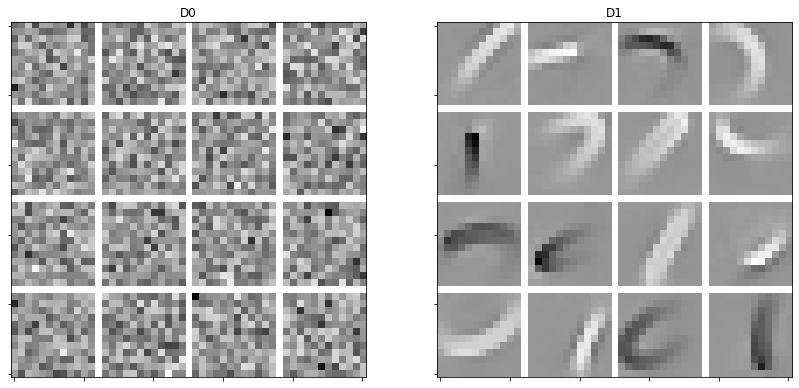

In [5]:
# visualization of basis functions
# D0 is the random noise initialization
# D1 is the final learned basis functions to be used for reconstruction
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0), title='D0', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1), title='D1', fig=fig)
fig.show()
plot.savefig('sparse_features.png', format='png')

In [6]:
# testing reconstruction on 2 images 
lmbda = 0.01
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})
b = cbpdn.ConvBPDN(D1, train_ims[:2,:,:], lmbda, opt, dimK=0)
X = b.solve()
print("ConvBPDN solve time: %.2fs" % b.timer.elapsed('solve'))

Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  2.06e+01  1.79e+01  2.70e+02  4.17e-01  1.02e+01  1.50e+00
   1  1.21e+01  7.93e+00  4.15e+02  2.09e-01  5.19e+00  1.50e+00
   2  8.68e+00  2.58e+00  6.11e+02  2.38e-01  1.70e+00  2.93e-01
   3  9.33e+00  8.30e-01  8.50e+02  3.23e-01  6.41e-01  1.07e-01
   4  9.48e+00  5.89e-01  8.89e+02  3.34e-01  4.22e-01  7.40e-02
   5  8.89e+00  5.25e-01  8.37e+02  2.89e-01  3.15e-01  6.40e-02
   6  7.96e+00  4.85e-01  7.47e+02  2.21e-01  2.62e-01  6.40e-02
   7  7.52e+00  4.55e-01  7.06e+02  1.90e-01  2.18e-01  5.73e-02
   8  7.10e+00  4.37e-01  6.66e+02  1.62e-01  1.84e-01  5.21e-02
   9  6.51e+00  4.25e-01  6.09e+02  1.28e-01  1.60e-01  5.21e-02
  10  6.31e+00  4.16e-01  5.90e+02  1.15e-01  1.40e-01  4.53e-02
  11  6.11e+00  4.06e-01  5.70e+02  1.03e-01  1.20e-01  4.00e-02
  12  5.89e+00  3.95e-01  5.49e+02  9.07e-02  1.07e-01  3.61e-02
  13  5.68e+00  3.86e-01 

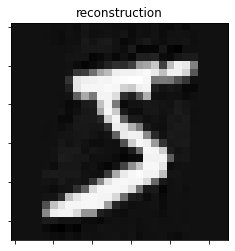

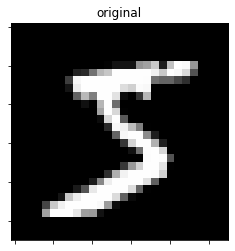

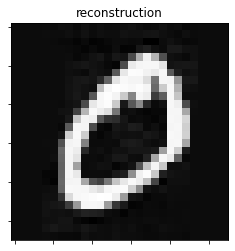

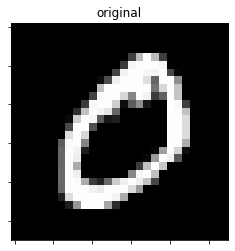

In [55]:
# visualizaing the reconstructions and comparing to original
shr = b.reconstruct().squeeze()
plot.imview(shr[0,:,:],'reconstruction')
plot.imview(train_ims[0,:,:],'original')

plot.imview(shr[1,:,:],'reconstruction')
plot.imview(train_ims[1,:,:],'original')


784


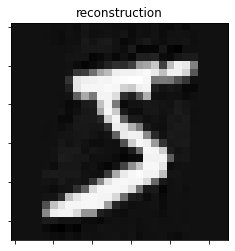

In [58]:
# saving the practice images before reconstructing 20k images
images_array = np.load('recon.npy')
image = images_array[0]
print(image.size)
plot.imview(image[:,:],'reconstruction')

# Preprocess the image if needed
# For example, convert to tensor and normalize
image = image / 255.0

In [16]:
# run reconstruction for 20k images
lmbda = 0.01
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})
b = cbpdn.ConvBPDN(D1, train_ims[:20000,:,:], lmbda, opt, dimK=0)
X = b.solve()
print("ConvBPDN solve time: %.2fs" % b.timer.elapsed('solve'))

shr = b.reconstruct().squeeze()
np.save('reconstruct_train_set2.npy', shr)

Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  5.85e+04  3.35e+04  2.50e+06  3.91e-01  6.11e+00  1.50e+00
   1  3.69e+04  4.62e+03  3.23e+06  1.60e-01  2.12e+00  1.50e+00
   2  3.92e+04  3.44e+03  3.58e+06  2.64e-01  7.26e-01  4.01e-01
   3  4.14e+04  1.90e+03  3.95e+06  3.05e-01  4.50e-01  2.36e-01
   4  3.97e+04  1.59e+03  3.81e+06  2.84e-01  3.20e-01  1.89e-01
   5  3.59e+04  1.54e+03  3.43e+06  2.17e-01  2.53e-01  1.89e-01
   6  3.41e+04  1.46e+03  3.26e+06  1.85e-01  2.14e-01  1.71e-01
   7  3.25e+04  1.39e+03  3.11e+06  1.59e-01  1.81e-01  1.54e-01
   8  3.02e+04  1.36e+03  2.88e+06  1.26e-01  1.57e-01  1.54e-01
   9  2.93e+04  1.34e+03  2.80e+06  1.14e-01  1.38e-01  1.35e-01
  10  2.85e+04  1.32e+03  2.72e+06  1.02e-01  1.21e-01  1.19e-01
  11  2.77e+04  1.29e+03  2.65e+06  9.12e-02  1.06e-01  1.07e-01
  12  2.70e+04  1.28e+03  2.57e+06  8.13e-02  9.32e-02  9.65e-02
  13  2.63e+04  1.27e+03 

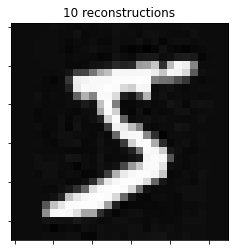

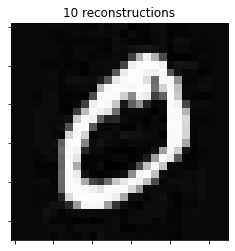

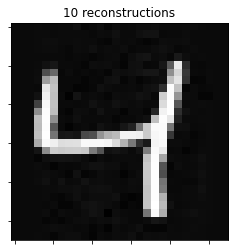

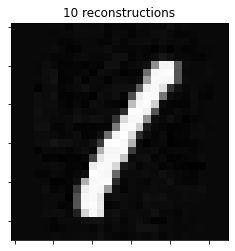

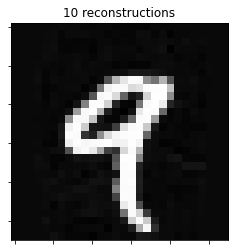

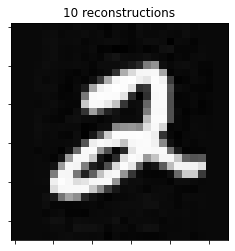

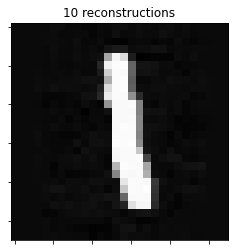

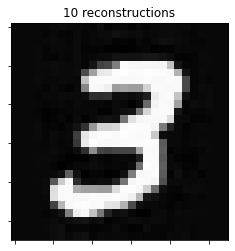

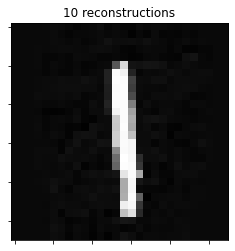

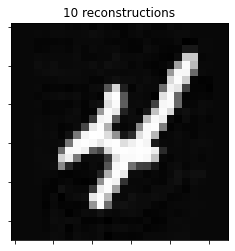

In [9]:
shr = b.reconstruct().squeeze()

for i in range(10):
    plot.imview(shr[i,:,:],'10 reconstructions')

In [18]:
# load in labels and save in .npz file to be used in adversarial-extension notebook
images_array = np.load('reconstruct_train_set2.npy')
labels_array = y[:20000]
np.savez('reconstruct_train_set2.npz', images=images_array, labels=labels_array)


0